In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, \
                            recall_score, f1_score, \
                            roc_auc_score, roc_curve, \
                            confusion_matrix

In [3]:
test_data = pd.read_csv("data/test.csv")
train_data = pd.read_csv("data/train.csv")
sample = pd.read_csv("data/sample_submission.csv")

In [20]:
# Function that receives original dataframe and cleans the data
# Actions performed: 
# - order by timestamp
# - change market_sentiment to numerical
# - change market_instability to numerical
# - replace all nan in other numerical with the previous value (or drop them otherwise)
# - change anonymous to the numerical part of the feature
# - set index to id
def clean_data(df_ini, sample_size):
    
    df_clean = df_ini[:sample_size].copy()
    
    # order by timestamp
    df_clean = df_clean.sort_values(by=['unix_timestamp'])

    
    # market_sentiment cleaning: replace tp numerical
    replace_dic_sentiment = {"Very Positive": 2, "Positive": 1, "Neutral": 0, "Very Negative": -2, "Negative": -1}
    df_clean["market_sentiment"] = df_clean["market_sentiment"].replace(replace_dic_sentiment)    
#     df_clean["market_sentiment"] = df_clean["market_sentiment"].replace({np.nan: 0})
    
    # market_instability cleaning
    replace_dic_instability = {'None' : 0, 'Low' : 1, 'Medium' : 2, 'High' : 3}
    df_clean["market_instability"] = df_clean["market_instability"].replace(replace_dic_instability)    

        
    # fill all NaNs with nearest past value
    df_clean = df_clean.ffill() 
#     print(np.sum(df_clean.isna())) #check that there are no more NaNs   

    # drop remaining NaNs
    df_clean = df_clean.dropna() 
#     print(np.sum(df_clean.isna())) #check that there are no more NaNs   
        
    # Anonymous (there are no NaN's)
    #df_clean['anonymous'] = df_clean['anonymous'].str.split('_').str[1].astype(int)
    
    
#     # replace all nan in other numerical with the median value
#     df_col = df_clean.columns
#     fill_median_dic = {}
#     for col in df_col:
#         col_str = str(col)
#         fill_median_dic[col_str] = df_clean[col_str].median()
#     print(fill_median_dic)
#     df_clean = df_clean.fillna(fill_median_dic)   
    
    
    # lastly set index to id
    df_clean = df_clean.set_index('id')
    
    return df_clean

In [21]:
train_df = pd.read_csv("data/train.csv")


In [22]:
train_df = clean_data(train_df, len(train_df))

/tmp/ipykernel_81053/1887479838.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(np.bool)


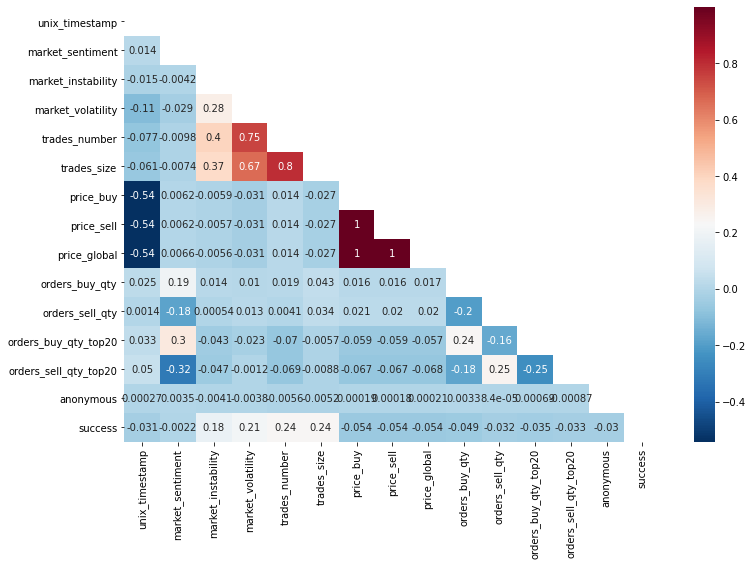

In [7]:
cor_mat = train_df.corr(method="spearman")
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(np.bool)
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

plt.figure(figsize = (12,8)) # <-- just sets the figure size 
sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

In [23]:
def feature_engineering(df):
    _df = df.copy()
   
    # Sell-buy ratios
    #_df['price_ratio'] = _df['price_sell']/_df['price_buy']
    _df['price_ratio'] = (_df['price_sell']-_df['price_buy'])/_df["price_buy"]
    
    _df['price_sell_difference'] = (_df['price_sell']-_df['price_global'])/_df['price_global']
    
    _df['orders_qty_top20_ratio'] = _df['orders_sell_qty_top20']/_df['orders_buy_qty_top20']
    _df['orders_qty_ratio'] = _df['orders_sell_qty']/_df['orders_buy_qty']
    _df['trades_ratio'] = _df['trades_size']/_df['trades_number'] # Average size per trade
    
    # Time features
    df_date = pd.to_datetime(_df['unix_timestamp'], unit = 'ms')
    _df['hour_of_the_day'] = df_date.dt.hour
    _df['minute_of_the_hour'] = df_date.dt.minute

    return _df

In [24]:
train_df = feature_engineering(train_df)

/tmp/ipykernel_81053/1887479838.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(np.bool)


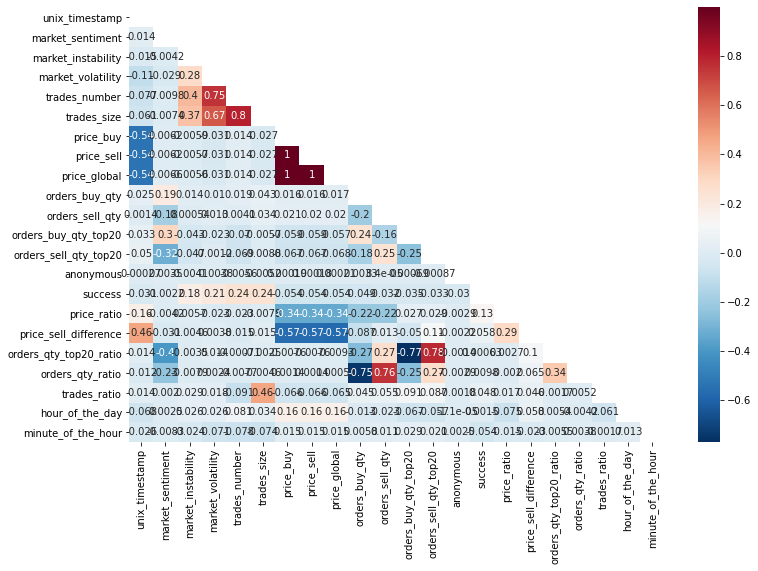

In [10]:
cor_mat = train_df.corr(method="spearman")
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(np.bool)
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

plt.figure(figsize = (12,8)) # <-- just sets the figure size 
sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

In [25]:
import category_encoders as ce

# initialize transformer with desired options
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='indicator')

# save data to scale (no need to reshape)
X = train_df[['anonymous']]

# fit transformer to data
ohe.fit(X)

# create new feature by transforming the data
X_ohe = ohe.transform(X)
X_ohe.sample(5, random_state=9)


/home/ana/.virtualenvs/hckt01/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,anonymous_category_85,anonymous_category_22,anonymous_category_133,anonymous_category_23,anonymous_category_14,anonymous_category_9,anonymous_category_18,anonymous_category_138,anonymous_category_46,anonymous_category_65,...,anonymous_category_132,anonymous_category_111,anonymous_category_19,anonymous_category_104,anonymous_category_122,anonymous_category_141,anonymous_category_40,anonymous_category_86,anonymous_category_127,anonymous_-1
id,,,,,,,,,,,,,,,,,,,,,
7Y588QG4S2OWMRO12N29MJEE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4J8GGCC5NINIQRUNM6YL5U7A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LYNS17TZB2Q3Z8V61V2BV82E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZCR1HLI0FN1ZC8AXOA5NSBCW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9GPM0RNNF9B1DCN31L0IT4IM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_df = pd.concat([train_df, X_ohe], axis=1)

In [30]:
#df_train_ready = train_df.set_index('id')
df_train_ready = train_df.drop(["unix_timestamp", "price_buy", "price_sell", "anonymous"],axis=1)
#df_train_ready = df_train_ready.set_index('id')

In [85]:
#df_train_ready=train_df

In [31]:
df_train_ready

,market_sentiment,market_instability,market_volatility,trades_number,trades_size,price_global,orders_buy_qty,orders_sell_qty,orders_buy_qty_top20,orders_sell_qty_top20,...,anonymous_category_132,anonymous_category_111,anonymous_category_19,anonymous_category_104,anonymous_category_122,anonymous_category_141,anonymous_category_40,anonymous_category_86,anonymous_category_127,anonymous_-1
id,,,,,,,,,,,,,,,,,,,,,
MIYIKL1LO0C2YJWEYVJD2QSR,2.0,0.0,0.00034,78.0,206.77,988.88298,5.50,14.95,93.53,179.09,...,0,0,0,0,0,0,0,0,0,0
YU8WZGAT0E8AHU44N52Y4O69,2.0,0.0,0.00034,78.0,206.77,988.84869,4.20,7.39,69.51,277.49,...,0,0,0,0,0,0,0,0,0,0
T88FOCZN28J115T6AM5X9QYZ,2.0,0.0,0.00038,96.0,206.77,989.03988,49.18,41.96,251.58,58.59,...,0,0,0,0,0,0,0,0,0,0
N8WDQ2NL2FYAA7YOC37Q1CTO,2.0,1.0,0.00045,137.0,338.77,989.57036,51.53,0.46,279.76,11.47,...,0,0,0,0,0,0,0,0,0,0
J7I57WWZYCR8LO7AZGKF7OOO,2.0,1.0,0.00049,158.0,350.32,989.75155,48.43,51.03,291.10,138.43,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0KHXENLCOUI3FYZUXOK8XAI5,0.0,0.0,0.00012,6.0,36.33,907.69417,0.55,24.70,44.02,548.44,...,0,0,0,0,0,0,0,0,0,0
IHKOYX6H90VU8DOKMGN8SFTN,0.0,0.0,0.00014,6.0,36.33,907.69417,0.55,9.45,111.05,474.89,...,0,0,0,0,0,0,0,0,0,0
LNHSDPFJQ2AW4EQX2XEJPJLB,0.0,0.0,0.00015,9.0,36.33,907.67893,0.13,25.24,107.81,490.77,...,0,0,0,0,0,0,0,0,0,0


In [32]:


# Getting our df into values
X = df_train_ready.drop(columns=["success"]).values
y = df_train_ready.success.values

# Using a split of 75-25 - we can try tunning these values later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [33]:
def perform_grid_search_and_return_best_model(grid_search):
    grid_search.fit(X_train, y_train)
    print("Best Parameters:")
    display(grid_search.best_estimator_.get_params())
    return grid_search.best_estimator_

In [34]:
# Plotting the AUC Score
def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    plt.figure(figsize=(8, 6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [35]:
# For the Hyperparameter Tunning, lets define here our Grid
hyper_parameters_grid = {
    'max_depth': range(9, 10),
    'n_estimators': range(10, 11)
}

grid_search = GridSearchCV(
    RandomForestClassifier(),
    hyper_parameters_grid,
    cv=5,
    scoring="roc_auc", # already takes into account the metric we are looking for, nice!
    return_train_score=True
)

best_model = perform_grid_search_and_return_best_model(grid_search)



Best Parameters:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

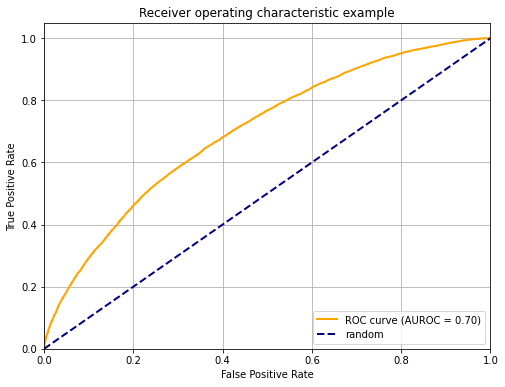

In [36]:
# Get predictions for our test set
y_test_pred = best_model.predict_proba(X_test)[:,1]

# AUC Score
roc_auc = roc_auc_score(y_true=y_test, y_score=y_test_pred)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_pred)
plot_roc_curve(roc_auc=roc_auc, fpr=fpr, tpr=tpr)